# Digit Recognizer Kaggle

- By Kenneth Preston
- Using the fastai library

In this notebook I am documenting my first submission to a Kaggle competition ever! This competition is in image recognition of handwritten digits. I will be using the fastai library that I was introduced to in the fast.ai course on deep learning. 

I have taken other introductory courses in deep learning which focused more on the theory and less on the implementation. This course has been very different in that it first focuses on teaching you the minimum necessary to required to get you successfully practicing deep learning. I love this approach! The instructor, Jeremy Howard (Kaggle's #1 competitor 2 years running), is fantastic. He teaches practical tactics first and introduces more and more theory over time. I highly recommended it to anyone interested in becoming a deep learning pracitioner.

Here is my first Kaggle Submission!

## Getting Data 

#### Normally I would use the kaggle data downloader app...

To start download kaggle data for competition (make sure to enroll in the competition first). Install the kaggle downloader from https://github.com/floydwch/kaggle-cli

In Anaconda prompt enter >kg download -u kaggleusername or Email -p password -c competition. In this case it will look something like this 
    kg download -u KennethPreston -p mypassword -c digit-recognizer

#### However,I wanted to get the actual images to make it easier to use fastai. So I downloaded them from here...

The images for this competition are available here:
https://www.kaggle.com/scolianni/mnistasjpg

## A few house keeping things

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd

In [3]:
import fastai

The next two items need to come back true so that we can access the GPU and torch to run our deep learning models.

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

## Setting up data for fastai

I created this notebook in the following folder:

In [6]:
import os
os.getcwd()

'/home/ken/fastai/courses/dl1'

Then I put down the path to where I saved the train and test folders.

In [7]:
PATH = "data/digit-recognizer/"

Just checking if my train and test folders are where I wanted them.

In [8]:
os.listdir(PATH)

['train', 'tmp', 'valid', 'models', 'test']

I then manually created a valid folder with the same subfolders as found in train.

In [9]:
os.listdir(PATH)

['train', 'tmp', 'valid', 'models', 'test']

Next I got a list of lists of all the image files saved in the 10 subfolders, each containing images of hand written digits 0 to 9.

### This step only needs to be done once! So for now I put these into markdown. To run them change them to 'code'.

import glob
train_numbers = [0,1,2,3,4,5,6,7,8,9]
for i in range(10):
    train_numbers[i] =(glob.glob("/home/ken/fastai/courses/dl1/data/digit-recognizer/train/"+str(i)+"/*.jpg"))

Next I randomly sampled 1000 cases to move into the validation folders.

train_numbers_for_valid = [0,1,2,3,4,5,6,7,8,9]
for i in range(10):
    train_numbers_for_valid[i] = random.sample(train_numbers[i], 1000)

Then I changes the path from train to valid and saved the new paths for the validation folders.

valid_new_path = [0,1,2,3,4,5,6,7,8,9]
for i in range(10):
    valid_new_path[i] = [w.replace('/train/', '/valid/') for w in train_numbers_for_valid[i]]

Here I flatten the list of lists for each folder down to one single flat list containing all the new paths

flat_list_valid = [item for sublist in valid_new_path for item in sublist]
flat_list_train_rm = [item for sublist in train_numbers_for_valid for item in sublist]

Finally, I move all the validation images from the train folder to the valid folder

for i in range(len(flat_list_train_rm)):
    shutil.move(flat_list_train_rm[i], flat_list_valid[i])

# Now the fun begins: lets train!

In [231]:
from IPython.display import HTML
HTML('<img src="https://media.giphy.com/media/qhTLyADlCa6A0/giphy.gif">')

In one of the first few lessons of fast.ai you are provided with a short list of steps to follow to achieve world class results in image classification. The example you go through is on the Cats Dogs dataset, but you are encouraged to conduct the same techniques on other datasets. I am going to put the claim to the test. I cheat a little and will add in the Test Time Augmentation trick at the end. There are other tricks the instructor, Jeremy Howard, provides. 

 ## 5 Steps to training a world class image classifier 

    1. Use lr_find() to find highest learning rate where loss is still clearly improving
    2. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
    3. Unfreeze all layers
    4. Set earlier layers to 3x-10x lower learning rate than next higher layer
    5. Train full network with cycle_mult=2 until over-fitting



In [22]:
arch=resnet34

In [26]:
sz = 28

In [45]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz,aug_tfms=transforms_basic , max_zoom=1.0), test_name='test')

### 1. Use lr_find() to find highest learning rate where loss is still clearly improving

In [46]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 421/500 [00:40<00:07, 10.33it/s, loss=3.15] 

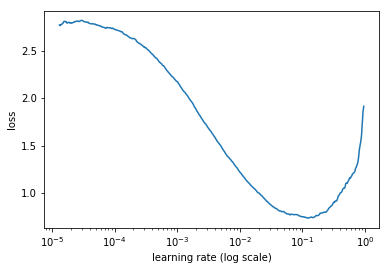

 84%|████████▍ | 421/500 [01:00<00:11,  7.00it/s, loss=3.15]

In [47]:
lrf=learn.lr_find()
learn.sched.plot()

looks my ideal learning rate is between 0.01 and 0.001. I will go with 0.01.

### 2. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1

In [48]:
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(0.01, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 15%|█▌        | 76/500 [00:07<00:43,  9.76it/s, loss=0.827]

Exception in thread Thread-24:
Traceback (most recent call last):
  File "/home/ken/.conda/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ken/.conda/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ken/.conda/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.387983   0.239979   0.92297   
    1      0.325205   0.210714   0.934315                    
    2      0.303633   0.187487   0.940585                    



[0.18748668, 0.9405851910828026]

### 3. Unfreeze all layers

In [49]:
learn.unfreeze()

### 4. Set earlier layers to 3x-10x lower learning rate than next higher layer

In [50]:
lr=np.array([1e-4,1e-3,1e-2])

### 5. Train full network with cycle_mult=2 until over-fitting

In [51]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.141009   0.094905   0.971238  
    1      0.117984   0.057439   0.981787                     
    2      0.080247   0.051912   0.983479                     
    3      0.065272   0.040204   0.986863                     
    4      0.048778   0.043961   0.985669                     
    5      0.036479   0.039226   0.987759                     
    6      0.028779   0.03746    0.987958                     



[0.037459902, 0.9879578025477707]

Next I will use TTA (Time Test Augmentation) to improve my results up to 0.9903 on the validation set. This suggests there is value using this technique when predicting my test set.

In [52]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)
accuracy_np(preds, y)

### Predicting the Labels for the Unlabelled Test cases (located in my 'test' folder of course).

I will use TTA for predicting the test cases since I saw it helped when predicting my validation set earlier.

In [69]:
multi_preds, y = learn.TTA(is_test=True)
preds = np.mean(multi_preds, 0)

Here I turn the predictions from logs to probabilities.

In [70]:
probs = np.exp(preds)

I check the shape and I can see that I have 28000 arrays of length 10 each.

In [71]:
probs.shape

(28000, 10)

Next I take a look at the classes for each item in my array. The labels correspond with the index values which makes things easier for me when extracting results

In [154]:
data.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

I use argmax which returns the indices of the maximum values along an axis.

In [119]:
Label = [np.argmax(i) for i in probs]

Here I get the id of the image by pulling out the number from the file names.

In [124]:
ImageId = [w.replace('test/img_', '') for w in data.test_ds.fnames]
ImageId = [w.replace('.jpg', '') for w in ImageId]
ImageId = [int(w) for w in ImageId]

Next I build a DataFrame of the results and sort them in order of ImageId

In [148]:
d ={'ImageId': ImageId, 'Label': Label}
df = pd.DataFrame(data=d)
df = df.sort_values(by='ImageId')

Saving the df to a csv and removing the index so it doesn't appear as a column in the submission file.

In [150]:
df.to_csv('kaggle submission', index=False)

# My First Kaggle Submission Ever!

Incredible! I just submitted to my first Kaggle competition ever and achieved a very impressive score with minimal effort. Checking out the lessons at fast.ai is certainly worth your time if you want to hit the ground running in deep learning.

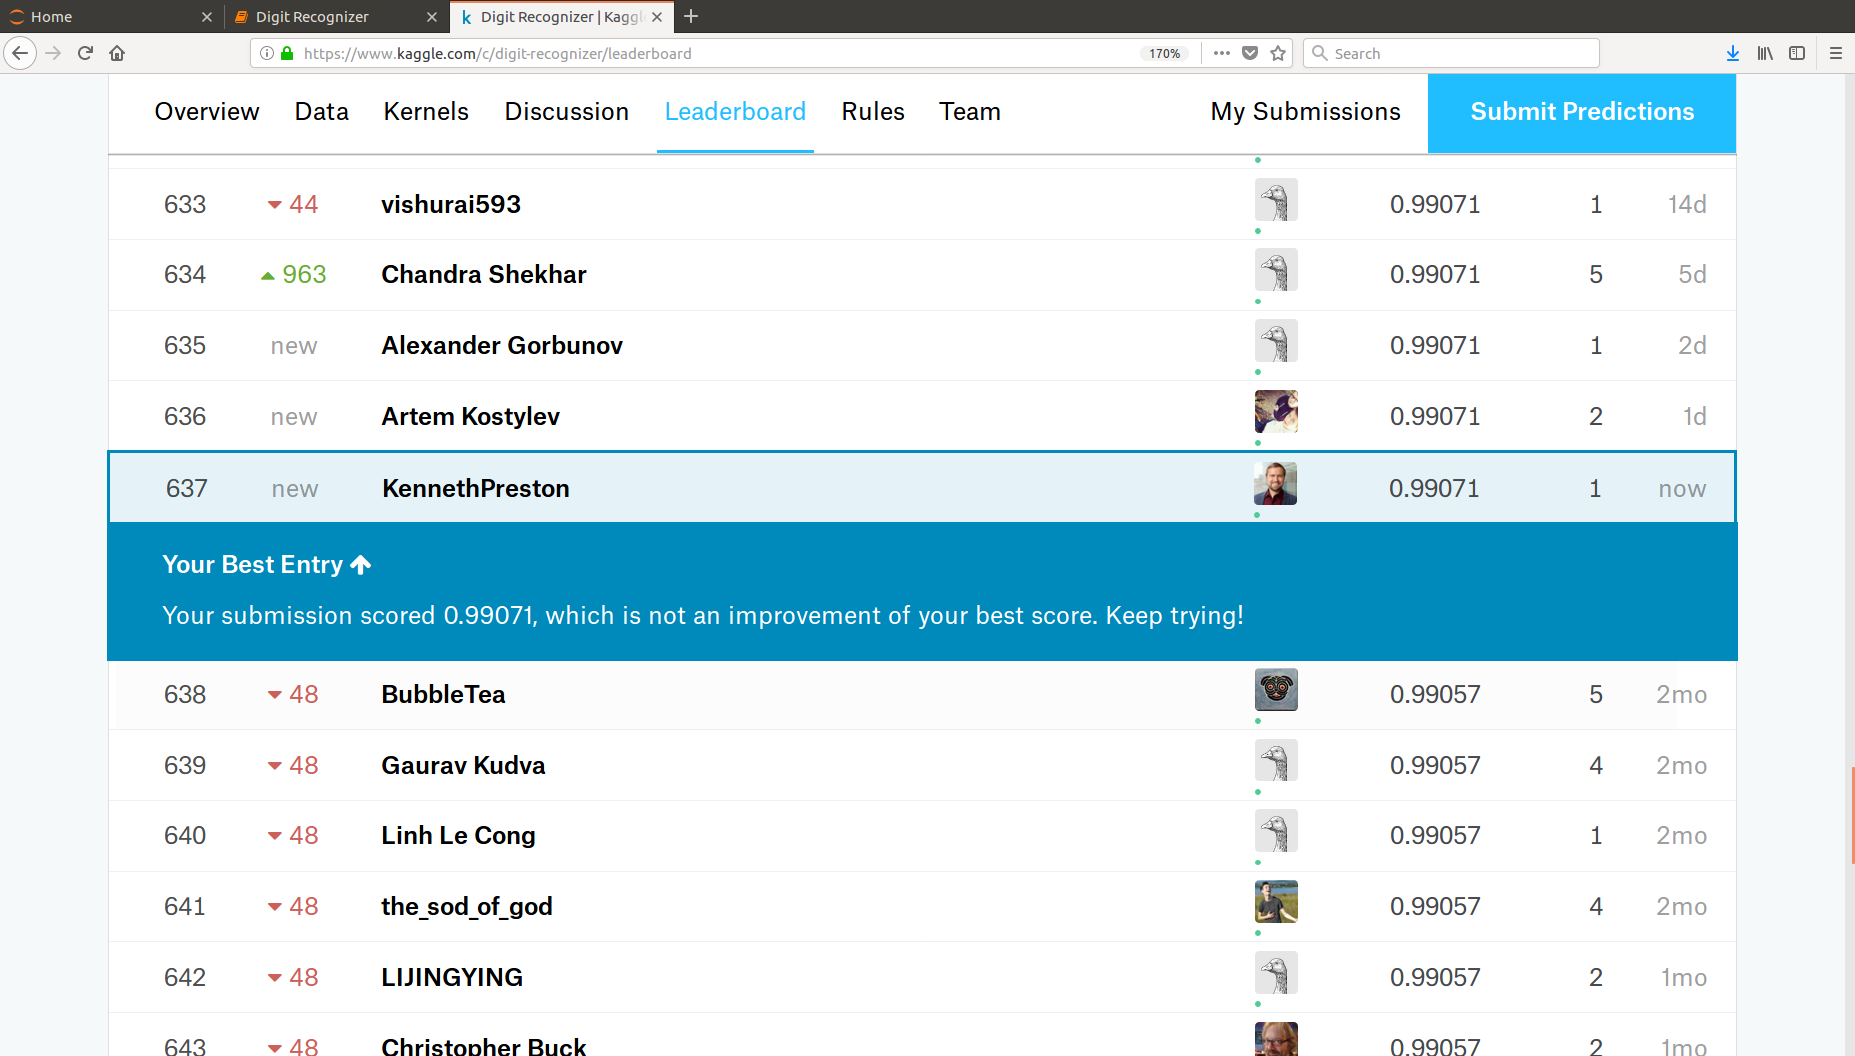

In [153]:
from IPython.display import Image
Image("data/digit-recognizer/My First Kaggle Submission.png")


So what comes next? My plan it to keep trying out kaggle submissions to keep practicing and applying what I learned to new cases. I will also continue on to the next lessons at fast.ai